# LASSO regression, as predicted by one-hot encoded values of year, country, language, and occupation.


#### Metric of evaluation type and justification: 
We use R-squared as a metric of evaluation. A linear relationship is assumed to exist between the group of independent variables year, country, language, and occupation and the dependent (target) variable Religion_over_science; hence the Lasso regression algorithm will evaluate the data. Lasso regression also lowers complexity and reduces noise in the model. R-squared will show a good measurement of how well the model fits the dependent variables based on the penalties enforced by Lasso regression.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
......................................................................................................................................................[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
......................................................................................................................................................[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
......................................................................................................................................................[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
................

,Alpha range,R2 (train),R2 (test)
0,0.000,0.474,0.476
1,0.033,0.474,0.476
2,0.067,0.474,0.476
3,0.100,0.474,0.476
4,0.133,0.474,0.476
5,0.167,0.474,0.476
6,0.200,0.474,0.476
7,0.233,0.474,0.476
8,0.267,0.474,0.476
9,0.300,0.474,0.476


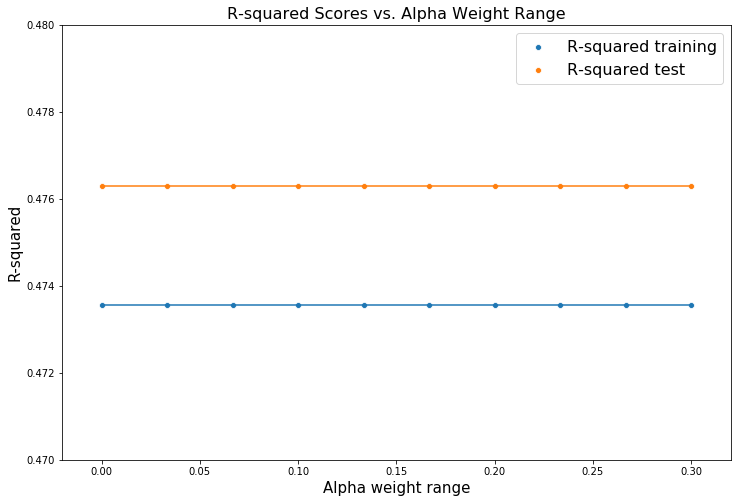

In [2]:
# load basic packages
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.3f}'.format
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv

# load visualization packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
colors = sns.color_palette()

# load sklearn packages
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder


# Import the cleaned dataset - data.csv.
df = pd.read_csv('/Users/frankstaszak/Desktop/207_team_project/data/data.csv')

# *** Define data, train, and evaluate model. ********************************************

# Define train/test data.
le = LabelEncoder()
df['language'] = le.fit_transform(df['language'].astype(str))
X = df.drop(columns=['Religion_over_science'])
# Define target (using dependent var - Religion_over_science)
y = df['Religion_over_science']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Tuning
# Use 5-fold cross validation for model evaluation.
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
# Use alpha range from 0.0001 up to 0.3 to remove unimportant variables.
alpha = np.linspace(0.0001, 0.3, 10)

# Encoders.
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore", sparse=False)
numerical_preprocessor = StandardScaler()

# Categorical and numeric cols.
cols_category = ['age', 'sex', 'year', 'country', 'language', 'occupation']
cols_numeric = [i for i in df.columns if i not in cols_category and i != 'Religion_over_science']
cols_X = [i for i in df.columns if i != 'Religion_over_science']
df.columns = ['Religion_over_science'] + cols_X

# Preprocessor.
preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, cols_category),
    ('standard_scaler', numerical_preprocessor, cols_numeric)])

r2_train_scores = []
r2_test_scores = []
for i in range(10):
    lasso_model = make_pipeline(
        preprocessor,
        LassoCV(alphas=alpha, cv=cv, n_jobs=1, verbose=True, random_state=123))
    lasso_model.fit(X_train, y_train)
    y_train_pred = lasso_model.predict(X_train)
    y_test_pred = lasso_model.predict(X_test)
    r2_train_scores.append(r2_score(y_train, y_train_pred))    
    r2_test_scores.append(r2_score(y_test, y_test_pred))   
# ****************************************************************************************

# Create and display report.
report = pd.DataFrame({
    'Alpha range': alpha,
    'R2 (train)': r2_train_scores,
    'R2 (test)': r2_test_scores
})
display(report)

# *** Visualize results, R-squared vs Alpha weights. *************************************

# Plot the R-squared scores with the given range of alpha weights.
fontsize = 16
plt.figure(figsize=(12,8))
plt.ylim([0.470, 0.480])
plt.title('R-squared Scores vs. Alpha Weight Range', fontdict={'fontsize': fontsize})
sns.scatterplot(alpha, r2_train_scores, label='R-squared training')
plt.plot(alpha, r2_train_scores)
sns.scatterplot(alpha, r2_test_scores, label='R-squared test')
plt.plot(alpha, r2_test_scores)
plt.xlabel('Alpha weight range', size=15)
plt.ylabel('R-squared', size=15)
plt.legend(prop={'size': fontsize})
plt.show()
# ****************************************************************************************


#### Evaluation: 
We observe that as the alpha weight increases, the R-squared score decreases. The coefficients in the regression model display a value closer to zero as the alpha weight increases. This relationship indicates that the observed outcomes of the model decline based on the degree to which the alpha weighting increased.

Furthermore, the regression modeled nearly forty percent of the outcomes at its peak.



<font size="2">Sources:</font><font size="1"> 
*  sklearn.linear_model.Lasso. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
*  sklearn.model_selection.RepeatedKFold. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html
*  Lasso and Elastic Net for Sparse Signals. https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_and_elasticnet.html#sphx-glr-auto-examples-linear-model-plot-lasso-and-elasticnet-py
*  sklearn.metrics.r2_score. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html
*  What is the Difference Between Test and Validation Datasets? Brownlee, Jason. 2017  https://machinelearningmastery.com/difference-test-validation-datasets/
*  Repeated k-Fold Cross-Validation for Model Evaluation in Python. Brownlee, Jason. 2020 https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/</font>

In [3]:
import time
from sklearn.inspection import permutation_importance



print('-'*100)
print('Feature importance based on feature permutation')
print('-'*100)

lasso_model = make_pipeline(
    preprocessor,
        LassoCV(alphas=alpha, cv=cv, n_jobs=1, verbose=True, random_state=123))
lasso_model.fit(X_train, y_train)
    
start_time = time.time()
result = permutation_importance(
    lasso_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

lasso_importances = pd.Series(result.importances_mean, index=X.columns)


----------------------------------------------------------------------------------------------------
Feature importance based on feature permutation
----------------------------------------------------------------------------------------------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
......................................................................................................................................................[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.2s finished


Elapsed time to compute the importances: 11.524 seconds


In [112]:
print("-" * 100)
print("Top 4 most important features")
print("-" * 100)
lasso_importances.sort_values(ascending=False).head(10)

----------------------------------------------------------------------------------------------------
Top 4 most important features
----------------------------------------------------------------------------------------------------


country      0.530
language     0.184
year         0.011
occupation   0.001
dtype: float64

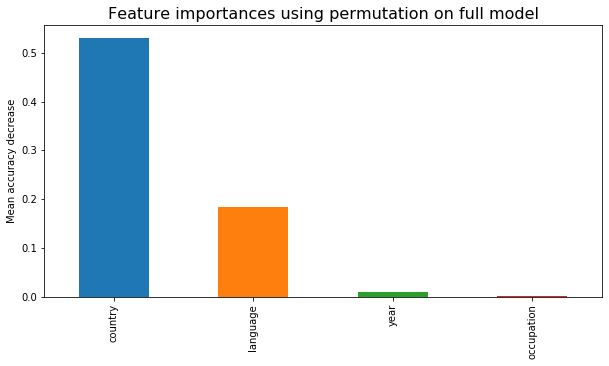

In [111]:
lasso_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,5), color=colors)
plt.title("Feature importances using permutation on full model", fontdict={'fontsize': fontsize})
plt.ylabel("Mean accuracy decrease")
plt.show()
plt.close()